In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# 4th-order Runge-Kutta

Again we'll copy over the RHS and `OrbitHistory`

In [3]:
G = 4*np.pi**2
M_sun = 1.0

def rhs(t, Y):
    
    # unpack just to make things easier to read
    x, y, vx, vy = Y
    
    xdot = vx
    ydot = vy
    
    r = np.sqrt(x * x + y * y)
    
    vxdot = -G * M_sun * x / r**3
    vydot = -G * M_sun * y / r**3
    
    return np.array([xdot, ydot, vxdot, vydot])

In [4]:
class OrbitHistory:
    """store the time history of the orbit solution"""
    
    def __init__(self):
        self.t = []
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        
    def store_current_solution(self, t, Y):
        self.t.append(t)
        self.x.append(Y[0])
        self.y.append(Y[1])
        self.vx.append(Y[2])
        self.vy.append(Y[3])
        
    def error_radius(self):
        """return the difference in the distance from the Sun"""
        R_orig = np.sqrt(self.x[0]**2 + self.y[0]**2)
        R_new = np.sqrt(self.x[-1]**2 + self.y[-1]**2)
        return np.abs(R_new - R_orig)        

    def error_position(self):
        """return the difference in the distance from the Sun"""
        dx = self.x[0] - self.x[-1]
        dy = self.y[0] - self.y[-1]
        return np.sqrt(dx**2 + dy**2)

    def plot(self, ax=None, label=None):
        """make a plot of the solution.  If ax is None we setup a figure
        and make the entire plot returning the figure object, otherwise, we
        just append the plot to a current axis"""

        fig = None
        
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)

            # draw the Sun
            ax.scatter([0], [0], marker=(20,1), color="y", s=250)

        # draw the orbit
        ax.plot(self.x, self.y, label=label)

        if fig is not None:
            ax.set_aspect("equal")
            ax.set_xlabel("x [AU]")
            ax.set_ylabel("y [AU]")
            
            return fig, ax

Now we consider a 4th order accurate method&mdash;4th order Runge-Kutta (RK4).  For many problems, this method will work very well and as a result, RK4 is widely used.

We'll consider a general system of first order differential equations:

$$\dot{\bf y} = {\bf f}({\bf y})$$

The advance begins by estimating the derivatives (righthand side or slope) at time $t^n$.  We'll call this ${\bf k}_1$.

$${\bf k}_1 = {\bf f}(t^n, {\bf y}^n)$$

![4th order Runge-Kutta k1](rk4_k1.png)

We then follow the slope ${\bf k}_1$ to the midpoint in time, $t^{n+1/2}$ and evaluate the slope there.  We call the new slope ${\bf k}_2$.

$${\bf k}_2 = {\bf f}(t^n + \tau/2, {\bf y}^n + (\tau/2) {\bf k}_1)$$

![4th order Runge-Kutta k2](rk4_k2.png)

We then go back to the start, but this time follow the new slope,
${\bf k}_2$ to the midpoint in time, $t^{n+1/2}$.  We again evaluate the slope here, and call it ${\bf k}_3$.

$${\bf k}_3 = {\bf f}(t^n + \tau/2, {\bf y}^n + (\tau/2) {\bf k}_2)$$


![4th order Runge-Kutta k3](rk4_k3.png)

Finally, we go back to the start and follow ${\bf k}_3$ for the full
timestep, to $t^{n+1}$ and evaluate the slope there, calling it ${\bf k}_4$.

$${\bf k}_4 = {\bf f}(t^n + \tau, {\bf y}^n + \tau {\bf k}_3)$$

![4th order Runge-Kutta k4](rk4_k4.png)

We then get the updated solution using a linear combination of the 4 slopes:

$${\bf y}^{n+1} = {\bf y}^n + \frac{\tau}{6} ({\bf k}_1 + 2 {\bf k}_2 + 2 {\bf k}_3 + {\bf k}_4)$$

![4th order Runge-Kutta final](rk4_final.png)

Note the similarity of RK4 to Simpson's rule for integration.

Here's our implementation

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='x [AU]', ylabel='y [AU]'>)

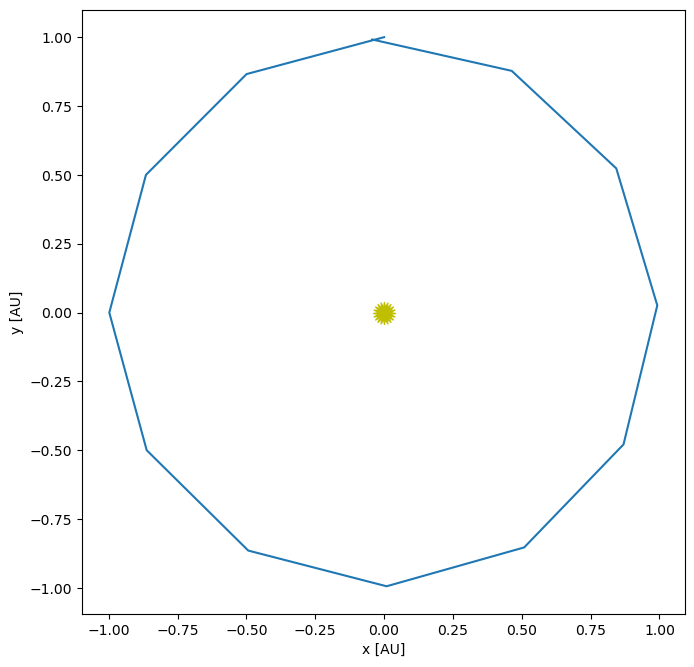

In [41]:
def euler_rk4(Y0, tau, T):

    # we'll return an orbit history object
    o = OrbitHistory()
    
    # storage for the new solution
    Y = Y0.copy()
    
    # initialize time
    t = 0
    
    # store the initial conditions
    o.store_current_solution(t, Y0)
    
    # main timestep loop
    while t < T:
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        k1 = rhs(t, Y)
         
        Ytmp = Y + 0.5 * tau * k1
        k2 = rhs(t + 0.5*tau, Ytmp)
        
        Ytmp = Y + 0.5 * tau * k2
        k3 = rhs(t + 0.5*tau, Ytmp)
        
        Ytmp = Y + tau * k3
        k4 = rhs(t + tau, Ytmp)
        
        # do the final update
        Y += tau / 6.0 * (k1 + 2*k2 + 2*k3 + k4)
        t += tau
        
        # store the state
        o.store_current_solution(t, Y)
        
    return o

Y0 = initial_conditions()

tau = 1.0/12.0

orbit = euler_rk4(Y0, tau, 1)

orbit.plot()

We can look at the convergence of RK4

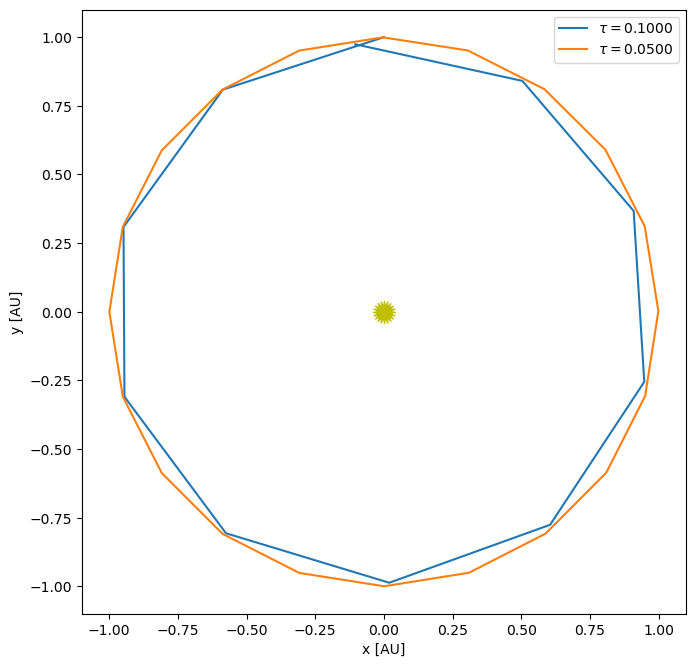

In [44]:
taus = [0.1, 0.05]

for n, tau in enumerate(taus):
    orbit = euler_rk4(Y0, tau, 1)
    
    if n == 0:
        fig, ax = orbit.plot(label=rf"$\tau = {tau:6.4f}$")
    else:
        orbit.plot(ax=ax, label=rf"$\tau = {tau:6.4f}$")

ax.legend()

In [45]:
for tau in [0.1, 0.05, 0.025, 0.0125, 0.00625]:
    o = euler_rk4(Y0, tau, 1)
    print(f"tau = {tau:8.5f}, error = {o.error_radius():10.5g} {o.error_position():10.5g}")

tau =  0.10000, error =   0.020244     0.1074
tau =  0.05000, error = 0.00054733  0.0039053
tau =  0.02500, error = 1.6779e-05 0.00016588
tau =  0.01250, error = 5.2225e-07 7.9308e-06
tau =  0.00625, error = 1.6305e-08 4.1917e-07


This is clearly converging faster than 2nd order.  4th order means that as we cut the timestep in half, the error should go down by $2^4$ or 16.

## Timestepping

In the above examples, we always kept the timestep $\tau$ fixed, but in general, finding the solution to a system of ODEs might have portions in time where the solution is changing rapidly and a smaller $\tau$ would be needed.  Likewise, is the solution is changing slowly, we can use a larger timestep.

Most ODE libraries use some form of local error estimation to measure how the large the error is in the solution and adjust the timestep (up or down) to achieve a desired accuracy.

To see why this might be needed, consider an elliptical orbit.

![elliptical orbit](ellipse_initial_cond.png)

The initial conditions for a planet at perihelion (on the +y axis) are:

$$x = 0$$

$$y = a (1 - e)$$

$$v_x = -\sqrt{\frac{GM_\star}{a} \frac{1+e}{1-e}}$$

$$v_y = 0$$

where $a$ is the length of the semi-major axis and $0 \le e < 1$ is the eccentricity.  For an eccentric orbit, the velocity changes throughout the orbit, so when the planet is at perihelion, the solution is changing rapidly.

<div class="alert alert-block alert-info">

**Exercise:**
    
Integrate an orbit with a large eccentricity (like $e = 0.8$).  Pick a timestep such that visually the orbit looks okay.  Now make a plot of the total energy per unit mass, $\mathcal{E}$ vs time:

$$\mathcal{E} = \frac{1}{2} |{\bf v}|^2 - \frac{GM_\star}{r}$$

At what point in the orbit is the energy conservation the worst?    
</div>

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='x [AU]', ylabel='y [AU]'>)

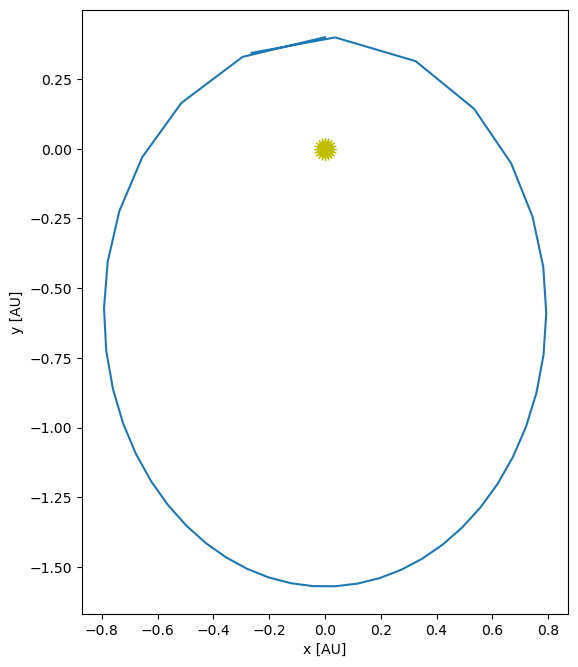

In [48]:
a = 1.0
e = 0.6

T = 1
x0 = 0
y0 = a * (1 - e)
vx0 = -np.sqrt(G*M_sun/a * (1 + e)/(1 - e))
vy0 = 0

Y0 = np.array([x0, y0, vx0, vy0])

tau = 0.025

orbit = euler_rk4(Y0, tau, 1)

orbit.plot()

We can compute the energy / unit mass now.

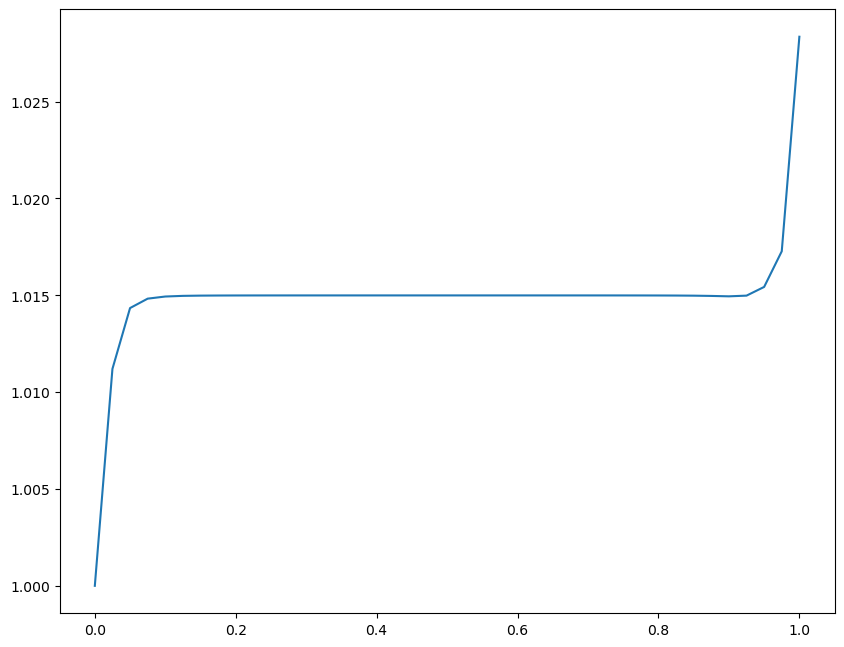

In [49]:
x = np.array(orbit.x)
y = np.array(orbit.y)
vx = np.array(orbit.vx)
vy = np.array(orbit.vy)
t = np.array(orbit.t)

E = 0.5*(vx**2 + vy**2) - G*M_sun/np.sqrt(x**2 + y**2)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t, E/E[0])

Notice that the energy conservation is not good, and the conservation is worst at perihelion when the solution is changing fastest.